In [1]:
import yfinance as yf
import pandas as pd
import seaborn as sns
import numpy as np
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers, losses
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from pathlib import Path
from loguru import logger
from concurrent.futures import ProcessPoolExecutor
from scipy.stats import skew, kurtosis

from src.universe import Universe
from src.utils import time_series_generator
from src.metrics import plot_mse, generate_report
from src.model.deepar import DeepAR

2023-04-23 23:40:27.447837: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
inception_date = '2022-03-31'
ONE_YEAR_TRADE_DAYS = 252
TWO_YEAR_TRADE_DAYS = ONE_YEAR_TRADE_DAYS * 2
WIN_LEN = 30
UNIVERSE_SIZE = 2500
EPOCH = 20
BATCH_SIZE = 16

In [3]:
universe = Universe()

In [4]:
liquid_ticker_ret = universe.get_liquid_ticker_return('2022-03-31')

/Users/guzhicheng/Desktop/HKUST_course/Spring/6000M/proj2/src/universe.py:20: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  universe = pd.read_csv(self._root / f'{inception_date}.csv', squeeze=True)
100%|██████████| 2500/2500 [00:05<00:00, 420.13it/s]


<Axes: ylabel='Density'>

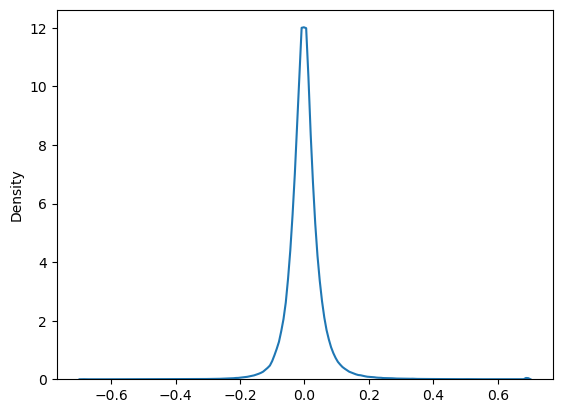

In [5]:
ret_train = liquid_ticker_ret.loc[:inception_date].iloc[-TWO_YEAR_TRADE_DAYS-WIN_LEN:]
train_index = ret_train.loc[:inception_date].iloc[-TWO_YEAR_TRADE_DAYS:].index
train_flat = ret_train.values.flatten()
train_flat = train_flat[train_flat != 0]
m = train_flat.mean()
s = train_flat.std()
train_flat = train_flat.clip(m-2*s, m+2*s)
sns.kdeplot(train_flat)

In [6]:
ret_train = ret_train.clip(m-2*s, m+2*s)
X, y = time_series_generator(ret_train, WIN_LEN)

In [7]:
X_train, X_val, y_train, y_val = train_test_split(X,y)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((378, 30, 2500), (126, 30, 2500), (378, 2500), (126, 2500))

In [8]:
deepar = DeepAR(WIN_LEN, UNIVERSE_SIZE)

In [9]:
deepar.build_and_compile()

2023-04-23 23:40:38.718576: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
deepar.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30, 2500)]        0         
                                                                 
 lstm (LSTM)                 (None, 248)               2727008   
                                                                 
 dense (Dense)               (None, 35)                8715      
                                                                 
 gaussian_layer (GaussianLay  ((None, 2500),           180000    
 er)                          (None, 2500))                      
                                                                 
Total params: 2,915,723
Trainable params: 2,915,723
Non-trainable params: 0
_________________________________________________________________


In [11]:
esc = tf.keras.callbacks.EarlyStopping(
    monitor='val_mse',
    patience=2,
    mode='auto',
)
deepar.fit(
    x=X_train, y=y_train, validation_data=(X_val, y_val), 
    epochs=EPOCH, batch_size=BATCH_SIZE,
    callbacks=[esc]
    )

Train on 378 samples, validate on 126 samples


2023-04-23 21:33:13.279563: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled


In [ ]:
## get ticker returns
test_start_date = liquid_ticker_ret.loc[:inception_date].iloc[-WIN_LEN:].index[0]
ret_test = liquid_ticker_ret.loc[test_start_date:].iloc[:ONE_YEAR_TRADE_DAYS + WIN_LEN+1]
ret_test = ret_test.clip(m-2*s, m+2*s)
X_test, y_test = time_series_generator(ret_test, WIN_LEN)

In [ ]:
test_index = ret_test.loc[inception_date:].iloc[1:ONE_YEAR_TRADE_DAYS].index
test_index

Index(['2022-04-01', '2022-04-04', '2022-04-05', '2022-04-06', '2022-04-07',
       '2022-04-08', '2022-04-11', '2022-04-12', '2022-04-13', '2022-04-14',
       ...
       '2023-03-20', '2023-03-21', '2023-03-22', '2023-03-23', '2023-03-24',
       '2023-03-27', '2023-03-28', '2023-03-29', '2023-03-30', '2023-03-31'],
      dtype='object', length=251)

In [ ]:
y_pred_train_mu = deepar.predict_mu(X)
y_pred_test_mu = deepar.predict_mu(X_test)

y_pred_train_rand = deepar.predict_rand(X)
y_pred_test_rand = deepar.predict_rand(X_test)

/Users/guzhicheng/opt/anaconda3/envs/py39/lib/python3.9/site-packages/keras/engine/training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


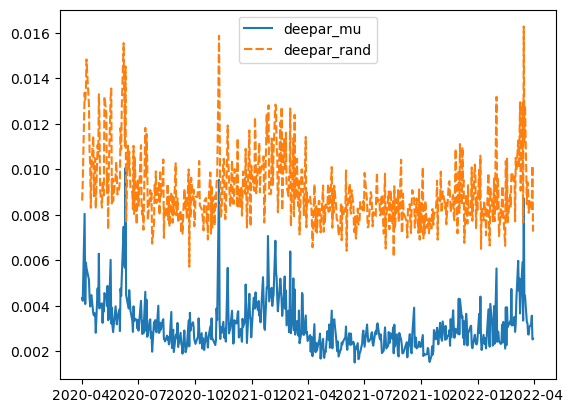

In [ ]:
ax_train, mse_df_train = plot_mse([y_pred_train_mu, y_pred_train_rand], y, ['deepar_mu', 'deepar_rand'], train_index)

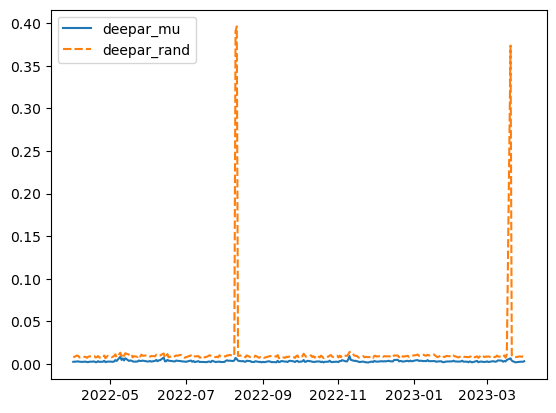

In [ ]:
ax_test, mse_df_test = plot_mse([y_pred_test_mu, y_pred_test_rand], y_test, ['deepar_mu', 'deepar_rand'], test_index)

In [ ]:
generate_report([y_pred_test_mu, y_pred_test_rand], y_test, ['deepar_mu', 'deepar_rand'])

,mse,corr,deviation
deepar_mu,0.003271,0.001510,987.295217
deepar_rand,0.013659,0.002878,3454.287430
